- Train Classifier MLP on all training dataset
- Sample equally 2500 datapoints from each class, with a total of 12_000 datapoints
- Use the hidden layer fc1 to get the new representation of these datapoints [12_000,128]
- Pass this vector to t-SNE or MDS

# Importing Modules and Loading Data

In [2]:
import numpy as np
import sys
import random 
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE,Isomap
import pickle
import matplotlib
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM
# torch.multiprocessing.set_start_method('spawn')
%matplotlib inline 
sys.path.append('gan')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
training_real = np.load('data/google/data_train.npz')
test_real = np.load('data/google/data_test.npz')
training_generated = np.load('data_generated/google/generated_data_train.npz')
# test_generated = np.load('data_generated/google/generated_data_test.npz')

In [4]:
real_train_X = torch.from_numpy(training_real['data_feature']).float() #[50000, 2500, 9]
real_train_Y = torch.from_numpy(training_real['data_attribute'])
real_train_Y_labels =  torch.argmax(real_train_Y,1) #(50000,)  returns a list of the class label, no one hot encoding any more

generated_train_X = torch.from_numpy(training_generated['data_feature']).float() #[50000, 2500, 9]
generated_train_Y = torch.from_numpy(training_generated['data_attribute'])
generated_train_Y_labels =  torch.argmax(generated_train_Y,1) #(50000,)  returns a list of the class label, no one hot encoding any more

real_test_X = torch.from_numpy(test_real['data_feature']).float() #[50000, 2500, 9]
real_test_Y = torch.from_numpy(test_real['data_attribute'])
real_test_Y_labels =  torch.argmax(real_test_Y,1) #(50000,)  returns a list of the class label, no one hot encoding any more


# Classify Data by Classes and Sample 3000 from each class

In [35]:
def get_one_class(X,Y,class_label): # X and Y are the whole datapoints that is consisted of many classes, Y is NOT One-Hot Encoded
    return X[np.where(Y==class_label)], Y[np.where(Y==class_label)]

def get_sample(X,Y,n_samples):
    randomList = random.sample(range(0, Y.shape[0]), n_samples)
    return X[randomList], Y[randomList]

In [36]:
################################################REAL DATA################################################

#After getting the actual samples of class A -> we can then flatten the datapoints if needed
real_train_X_0, real_train_Y_labels_0 = get_one_class(real_train_X, real_train_Y_labels, 0) # [6529, 2500, 9]  , (6529,)
real_train_X_1, real_train_Y_labels_1 = get_one_class(real_train_X, real_train_Y_labels, 1) # [16156, 2500, 9] , (16156,)
real_train_X_2, real_train_Y_labels_2 = get_one_class(real_train_X, real_train_Y_labels, 2) # [21276, 2500, 9] , (21276,)
real_train_X_3, real_train_Y_labels_3 = get_one_class(real_train_X, real_train_Y_labels, 3) # [6039, 2500, 9]  , (6039,)

In [34]:
real_train_Y

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)

In [37]:
n_samples=1000
real_train_X_0_sampled, real_train_Y_labels_0_sampled = get_sample(real_train_X_0,real_train_Y_labels_0,n_samples)
real_train_X_1_sampled, real_train_Y_labels_1_sampled = get_sample(real_train_X_1,real_train_Y_labels_1,n_samples)
real_train_X_2_sampled, real_train_Y_labels_2_sampled = get_sample(real_train_X_2,real_train_Y_labels_2,n_samples)
real_train_X_3_sampled, real_train_Y_labels_3_sampled = get_sample(real_train_X_3,real_train_Y_labels_3,n_samples)

In [38]:
real_train_X_12_000 =torch.cat((real_train_X_0_sampled,real_train_X_1_sampled,real_train_X_2_sampled,real_train_X_3_sampled)).float()
real_train_Y_12_000 =torch.cat((real_train_Y_labels_0_sampled,real_train_Y_labels_1_sampled,real_train_Y_labels_2_sampled,real_train_Y_labels_3_sampled))

In [39]:
################################################Generated DATA################################################

#After getting the actual samples of class A -> we can then flatten the datapoints if needed
generated_train_X_0, generated_train_Y_labels_0 = get_one_class(generated_train_X,generated_train_Y_labels,0) #  [6383, 2500, 9] , (6383)
generated_train_X_1, generated_train_Y_labels_1 = get_one_class(generated_train_X,generated_train_Y_labels,1) #  [17366, 2500, 9] , (17366,)
generated_train_X_2, generated_train_Y_labels_2 = get_one_class(generated_train_X,generated_train_Y_labels,2) #  [21559, 2500, 9] , (21559,)
generated_train_X_3, generated_train_Y_labels_3 = get_one_class(generated_train_X,generated_train_Y_labels,3) #  [4692, 2500, 9] ,  (4692,)


In [40]:
n_samples=1000
generated_train_X_0_sampled, generated_train_Y_labels_0_sampled = get_sample(generated_train_X_0, generated_train_Y_labels_0,n_samples)
generated_train_X_1_sampled, generated_train_Y_labels_1_sampled = get_sample(generated_train_X_1, generated_train_Y_labels_1,n_samples)
generated_train_X_2_sampled, generated_train_Y_labels_2_sampled = get_sample(generated_train_X_2, generated_train_Y_labels_2,n_samples)
generated_train_X_3_sampled, generated_train_Y_labels_3_sampled = get_sample(generated_train_X_3, generated_train_Y_labels_3,n_samples)


In [41]:
generated_train_X_12_000 =torch.cat((generated_train_X_0_sampled,generated_train_X_1_sampled,
                                     generated_train_X_2_sampled,generated_train_X_3_sampled)).float()
generated_train_Y_12_000 =torch.cat((generated_train_Y_labels_0_sampled,generated_train_Y_labels_1_sampled,
                                     generated_train_Y_labels_2_sampled,generated_train_Y_labels_3_sampled))

# MLP Model

In [46]:
class MLPModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # need to be (self) in order to be optimized and part of model
        self.flatten= nn.Flatten(start_dim=1)
        self.fc1 =  nn.Linear(22500,128) # 2500 * 9
        #self.fc1 =  nn.Linear(9,128) # 2500 * 9
        self.relu= nn.ReLU()
        self.fc2 = nn.Linear(128,4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.fc2(self.relu(self.fc1(self.flatten(x))))
        # x = self.fc2(self.relu(self.fc1(x)))
        return self.softmax(x)
    
    def get_hidden_view(self,x): #128 nodes
        return self.fc1(self.flatten(x))
        #return self.fc1(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
#         print(y_hat.shape) # The problem now is that we have class for each timestep, and y is ([64, 2500, 4])
#         print(y.shape)
        loss = F.cross_entropy(y_hat, y) #y_hat is (N, C) and y is (N)
        acc = FM.accuracy(y_hat, y)
        self.log('accuracy',acc, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        return {'loss': loss,'acc':acc}
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) #y_hat is (N, C) and y is (N)
        acc = FM.accuracy(y_hat, y)
        self.log('accuracy',acc, on_epoch=True,prog_bar=True, logger=True)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
params = {'shuffle': True,'num_workers': 0,'batch_size':64}


# Train and Get Hidden Representations

In [47]:
################################################REAL DATA################################################
# del train_dataloader
# # del test_dataloader
# del dataset
torch.cuda.empty_cache()
if __name__ == '__main__':
    dataset = torch.utils.data.TensorDataset(real_train_X.to(device),real_train_Y_labels.to(device))
    train_dataloader  = torch.utils.data.DataLoader(dataset, **params)
    dataset =  torch.utils.data.TensorDataset(real_test_X.to(device),real_test_Y_labels.to(device))
    test_dataloader  = torch.utils.data.DataLoader(dataset)
    model = MLPModel()

trainer = pl.Trainer(gpus=1,max_epochs=100,progress_bar_refresh_rate=1)
trainer.fit(model,train_dataloader)
# trainer.test(test_dataloaders=test_dataloader) # No need to repass (model), It will by itself work from test_step


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | fc1     | Linear  | 2.9 M 
2 | relu    | ReLU    | 0     
3 | fc2     | Linear  | 516   
4 | softmax | Softmax | 0     
------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.523    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 4])
torch.Size([64])
t

/rhome/yelnady/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [39]:
real_train_X_hidden.size()


torch.Size([4000, 128])

In [47]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter


In [59]:
writer = SummaryWriter('runs/tsne_without_mlp')
# writer.add_embedding(real_train_X_12_000,metadata=real_train_Y_12_000)
writer.add_embedding(nn.Flatten(start_dim=1)(real_train_X_12_000),metadata=real_train_Y_12_000)
writer.close()

In [58]:
nn.Flatten(start_dim=1)(real_train_X_12_000).shape


torch.Size([4000, 22500])

In [49]:
generated_train_X_hidden = model.get_hidden_view(generated_train_X_12_000) # [12_000, 128]

In [51]:
writer = SummaryWriter('runs/tsne_generated')
writer.add_embedding(generated_train_X_hidden,metadata=generated_train_Y_12_000)
writer.close()

In [18]:
################################################GENERATED DATA################################################
# del train_dataloader
# del test_dataloader
# del dataset
if __name__ == '__main__':
    dataset = torch.utils.data.TensorDataset(generated_train_X.to(device),generated_train_Y_labels.to(device))
    train_dataloader  = torch.utils.data.DataLoader(dataset, **params)
    model2 = MLPModel()

trainer2 = pl.Trainer(gpus=1,max_epochs=100,progress_bar_refresh_rate=1)
trainer2.fit(model2,train_dataloader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | fc1     | Linear  | 2.9 M 
2 | relu    | ReLU    | 0     
3 | fc2     | Linear  | 516   
4 | softmax | Softmax | 0     
------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params


Training: 0it [00:00, ?it/s]

1

In [19]:
generated_train_X_hidden = model2.get_hidden_view(generated_train_X_12_000) # [10000, 128]

In [ ]:
np.savetxt("generated_train_X_12_000.tsv", generated_train_X_hidden.cpu().detach().numpy(), delimiter="\t")

# RUN t-SNE using hidden representation from MLP

In [45]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/tsne_experiment_1')

In [ ]:
!tensorboard --logdir=runs

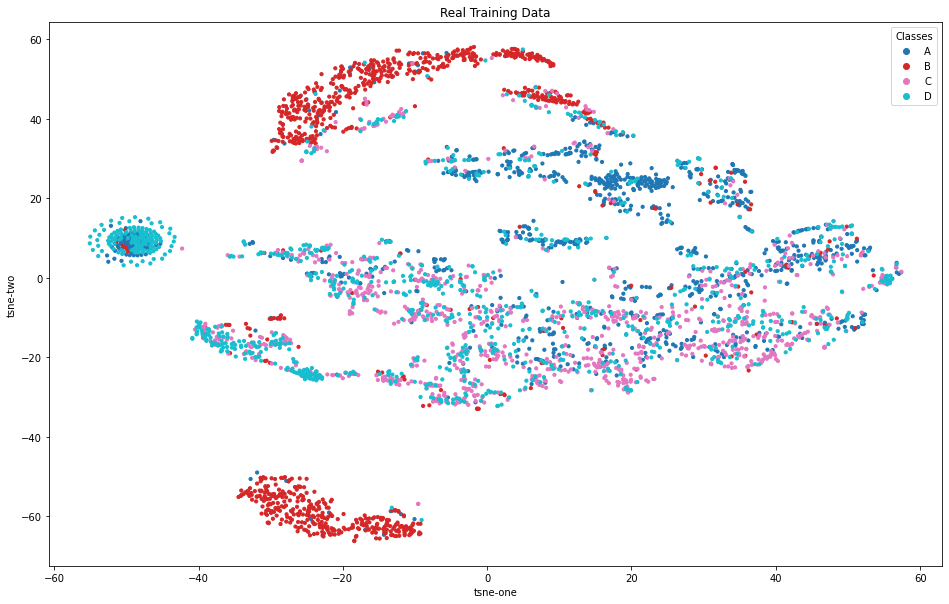

In [52]:
################################################REAL DATA################################################
tsne1 = TSNE(n_components=2,random_state=4,perplexity=50)
real_train_X_tsne = tsne1.fit_transform(real_train_X_hidden.cpu().detach().numpy()) # [10000, 128] -> [10000, 2]

ax = plt.figure(figsize=(16,10)).gca()
scatter = plt.scatter(
    x=real_train_X_tsne[:,0], 
    y=real_train_X_tsne[:,1], 
    c=real_train_Y_12_000, 
    cmap='tab10',
    marker=".",
    s=40.
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_title('Real Training Data')
classes = ['A', 'B', 'C','D']
plt.legend(handles=scatter.legend_elements()[0], labels=classes,title='Classes')
plt.savefig('Real Training Data.png',facecolor='white',dpi=160, bbox_inches='tight')

plt.show()

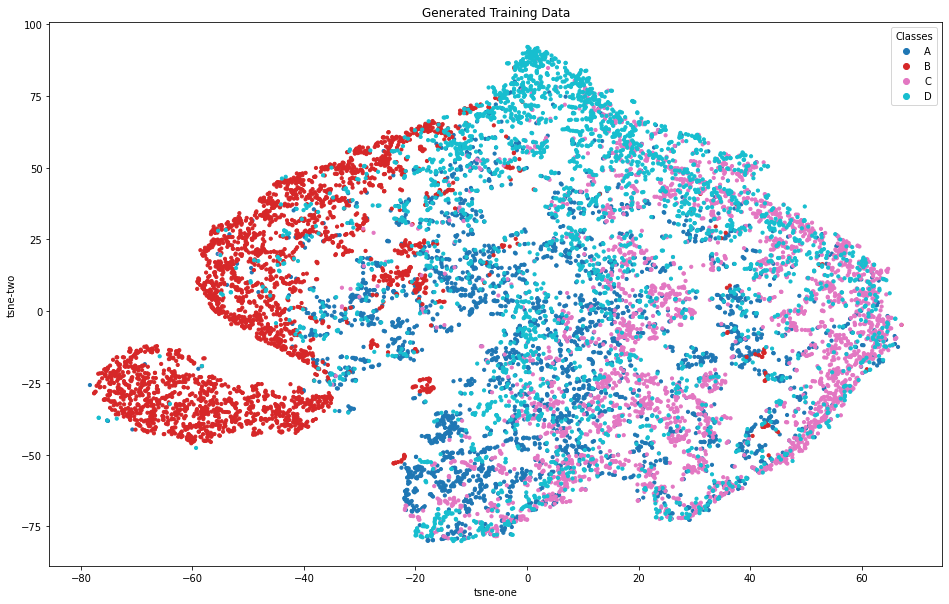

In [22]:
## GENERATED DATA################################################
tsne2 = TSNE(n_components=2,random_state=4,perplexity=40)
generated_train_X_tsne = tsne2.fit_transform(generated_train_X_hidden.cpu().detach().numpy()) # [10000, 128] -> [10000, 2]

ax = plt.figure(figsize=(16,10)).gca()
scatter = plt.scatter(
    x=generated_train_X_tsne[:,0], 
    y=generated_train_X_tsne[:,1], 
    c=generated_train_Y_12_000, 
    cmap='tab10',
    marker=".",
    s=40.
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_title('Generated Training Data')
classes = ['A', 'B', 'C','D']
plt.legend(handles=scatter.legend_elements()[0], labels=classes,title='Classes')
plt.savefig('Generated Training Data.png',facecolor='white',dpi=160, bbox_inches='tight')

plt.show()

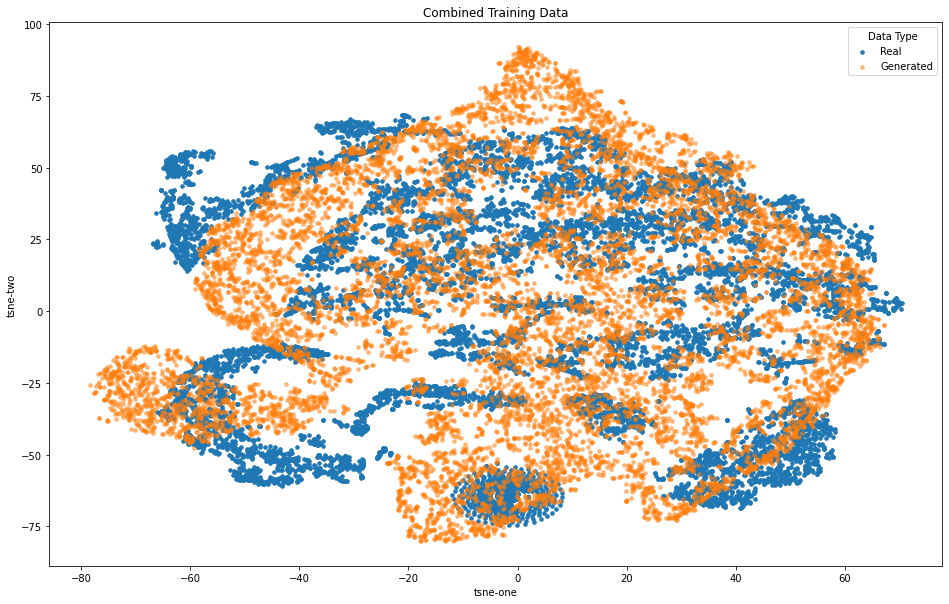

In [23]:
################################################COMBINED DATA################################################
# combined_train_X_tsne = np.concatenate((real_train_X_tsne,generated_train_X_tsne))
# combined_train_Y_sk = np.concatenate((real_train_Y_sk[randomList],generated_train_Y_12_000))#[100000, 2500, 9]

# Here rather than concatenating and so on --> we need to plot real and generated on top of each other and see if they are matching or not
ax = plt.figure(figsize=(16,10)).gca()
scatter = plt.scatter(
    x=real_train_X_tsne[:,0], 
    y=real_train_X_tsne[:,1], 
    cmap='tab10',
    marker=".",
    s=50.,
    label='Real'
)
scatter = plt.scatter(
    x=generated_train_X_tsne[:,0], 
    y=generated_train_X_tsne[:,1], 
    cmap='tab10',
    marker=".",
    s=50.,
    label='Generated',
    alpha=0.5
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_title('Combined Training Data')
plt.legend(title='Data Type')
plt.savefig('Combined Training Data.png',facecolor='white',dpi=160,bbox_inches='tight')

plt.show()

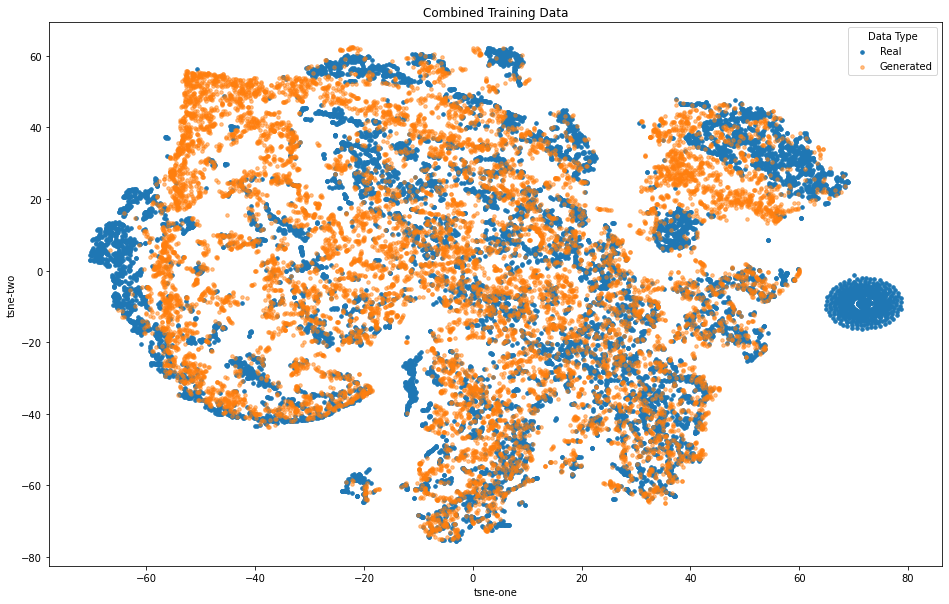

In [21]:
tsne3 = TSNE(n_components=2,random_state=4,perplexity=50)
combined_train_X_tsne = tsne3.fit_transform(torch.cat((real_train_X_hidden,generated_train_X_hidden)).cpu().detach().numpy()) # [24_000, 128] -> [24_000, 2]


ax = plt.figure(figsize=(16,10)).gca()
scatter = plt.scatter(
    x=combined_train_X_tsne[:12_000,0], 
    y=combined_train_X_tsne[:12_000,1], 
    cmap='tab10',
    marker=".",
    s=50.,
    label='Real'
)
scatter = plt.scatter(
    x=combined_train_X_tsne[12_000:,0], 
    y=combined_train_X_tsne[12_000:,1], 
    cmap='tab10',
    marker=".",
    s=50.,
    label='Generated',
    alpha=0.5
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_title('Combined Training Data')
plt.legend(title='Data Type')
plt.savefig('Combined Training Data2.png',facecolor='white',dpi=160,bbox_inches='tight')

plt.show()

In [25]:
combined_train_X_tsne.shape

(24000, 2)